In [123]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"


import torch
from glob import glob
from tqdm import tqdm
from typing import List, Dict

In [124]:
def _flatten_s_test_list(s_test_list: List[torch.Tensor]) -> torch.Tensor:
    s_tests = [s_test.flatten() for s_test in s_test_list]
    return torch.cat(s_tests)


def _parse_file_name(file_name: str) -> Dict:
    base_file_name = os.path.basename(file_name)
    items = base_file_name.split(".")
    return {
        "correct": (True if items[1] == "only-correct" else False),
        "test_index": int(items[3]),
        "num_samples": int(items[4]),
        "batch_size": int(items[5]),
        "repetition": int(items[6]),
        "hostname": items[8],
    }


def _load_and_populate_dict_(file_name: str, dict_to_populate: Dict) -> None:
    data = torch.load(file_name)
    if data["test_index"] != dict_to_populate["test_index"]:
        raise ValueError
        
    if data["num_samples"] != dict_to_populate["num_samples"]:
        raise ValueError
        
    if data["batch_size"] != dict_to_populate["batch_size"]:
        raise ValueError
        
    if data["repetition"] != dict_to_populate["repetition"]:
        raise ValueError
        
    if data["correct"] != dict_to_populate["correct"]:
        raise ValueError

    dict_to_populate["time_elapsed"] = data["time_elapsed"]    
    dict_to_populate["s_test"] = _flatten_s_test_list(data["s_test"])


# output_collections = []
# for file_name in tqdm(glob("/export/home/hguo/Experiments/20200927/*")):
#     output_collection = _parse_file_name(file_name)
#     _load_and_populate_dict_(file_name, output_collection)
#     output_collections.append(output_collection)

100%|██████████| 553/553 [00:14<00:00, 37.08it/s]


In [2]:
import numpy as np
from tqdm import tqdm

def process_output_collection_(output_collection):
    for outputs in tqdm(output_collection):
        s_test_pytorch = outputs["s_test"]
        s_test = np.concatenate([X.numpy().flatten() for X in s_test_pytorch])
        outputs["s_test"] = s_test

    outputs_by_index = [[] for _ in range(5)]
    target_s_test = [None for _ in range(5)]
    for outputs in tqdm(output_collection):
        outputs_by_index[outputs["test_index"]].append(outputs)
        if outputs["num_samples"] == 1300 and outputs["batch_size"] == 128:
            target_s_test[outputs["test_index"]] = outputs["s_test"]

    for outputs in tqdm(output_collection):
        diff_norm = np.linalg.norm(outputs["s_test"] - target_s_test[outputs["test_index"]])
        outputs["diff_norm"] = diff_norm

    for outputs in tqdm(output_collection):
        outputs.pop("s_test")
    
    return output_collection

In [3]:
output_collections = [
    process_output_collection_(torch.load("/export/home/hguo/Experiments-backup/20200819/s_test_speedup.repetition-1.pt")),
    process_output_collection_(torch.load("/export/home/hguo/Experiments-backup/20200819/s_test_speedup.repetition-2.pt")),
    process_output_collection_(torch.load("/export/home/hguo/Experiments-backup/20200819/s_test_speedup.repetition-3.pt")),
    process_output_collection_(torch.load("/export/home/hguo/Experiments-backup/20200819/s_test_speedup.repetition-4.pt"))]

100%|██████████| 280/280 [00:00<00:00, 16656.10it/s]


In [4]:
import pandas as pd

In [5]:
dfs = [
    pd.DataFrame(output_collections[i])
    for i in range(4)]

In [6]:
dfs[0].repetition = 0
dfs[1].repetition = 1
dfs[2].repetition = 2
dfs[3].repetition = 3
df = pd.concat(dfs)

In [7]:
import matplotlib.pyplot as plt

In [8]:
from collections import defaultdict
dfmeans = df.groupby(["num_samples", "batch_size"]).mean()[["time_elapsed", "diff_norm"]]
dfstds = df.groupby(["num_samples", "batch_size"]).std()[["time_elapsed", "diff_norm"]]
time_data = defaultdict(dict)
diff_data = defaultdict(dict)
for row_m, row_s in zip(dfmeans.iterrows(), dfstds.iterrows()):
    if row_m[0] != row_s[0]:
        raise ValueError
    n, b = row_m[0]
    time_data[n][b] = (row_m[1].time_elapsed, row_s[1].time_elapsed)
    diff_data[n][b] = (row_m[1].diff_norm, row_s[1].diff_norm)
    
    
display(dfmeans.transpose())
display(dfstds.transpose())

num_samples       700                                               \
batch_size         1          2          4          8          16    
time_elapsed  26.08949  25.705064  26.101444  34.919042  64.288451   
diff_norm      0.00029   0.000278   0.000272   0.000270   0.000269   

num_samples                                            800              ...  \
batch_size           32          64          128        1          2    ...   
time_elapsed  116.410985  228.240465  437.667134  29.343180  28.958088  ...   
diff_norm       0.000268    0.000268    0.000268   0.000213   0.000211  ...   

num_samples         1200                   1300                        \
batch_size           64          128        1          2          4     
time_elapsed  390.896078  749.419505  47.757228  47.286877  48.128248   
diff_norm       0.000028    0.000028   0.000053   0.000038   0.000027   

num_samples                                                              
batch_size          8           16          32          64          128  
time_elapsed  64.685787  119.182558  215.814722  423.399045  811.821144  
diff_norm      0.000019    0.000013    0.000010    0.000008    0.000000  

[2 rows x 56 columns]

num_samples       700                                                     \
batch_size         1         2         4         8         16        32    
time_elapsed  0.975949  0.906657  0.885012  0.286376  0.693916  1.418668   
diff_norm     0.000258  0.000249  0.000241  0.000240  0.000238  0.000237   

num_samples                           800             ...      1200            \
batch_size         64        128       1         2    ...       64        128   
time_elapsed  3.281795  5.624692  1.125091  0.979305  ...  5.754181  9.773358   
diff_norm     0.000237  0.000236  0.000190  0.000188  ...  0.000025  0.000025   

num_samples       1300                                                    \
batch_size         1         2         4         8         16        32    
time_elapsed  1.690446  1.598413  1.227696  0.498685  1.316964  2.626159   
diff_norm     0.000053  0.000037  0.000026  0.000018  0.000013  0.000010   

num_samples                        
batch_size         64         128  
time_elapsed  6.110928  10.630009  
diff_norm     0.000008   0.000000  

[2 rows x 56 columns]

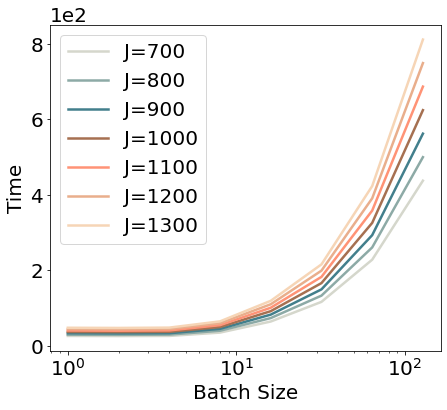

In [54]:
plt.figure(figsize=(7,6))
plt.rcParams.update({"font.size": 20})

for k in sorted(time_data.keys()):
    Ys = []
    Xs = []
    Ys_e = []
    for _k in sorted(time_data[k].keys()):
        Ys.append(time_data[k][_k][0])
        Ys_e.append(time_data[k][_k][1] * 10)
        Xs.append(_k)
    # plt.errorbar(Xs, Ys, yerr=Ys_e, label=f"N={k}")
    plt.errorbar(Xs, Ys, label=f"J={k}", linewidth=2.5, color={
        700: "#D5D7CC",
        800: "#8DAAA6",
        900: "#427F8C",
        1000: "#A67051",
        1100: "#FF9376",
        1200: "#E9AE8C",
        1300: "#F6D5B6"}[k])
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Time")
plt.xscale("log")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig("./20201013-stest-speedup-time.pdf")

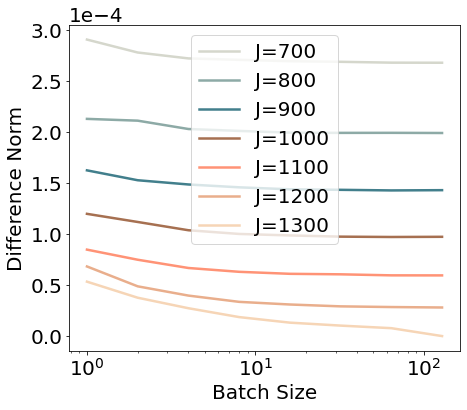

In [55]:
plt.figure(figsize=(7,6))
for k in sorted(diff_data.keys()):
    Ys = []
    Xs = []
    Ys_e = []
    for _k in sorted(diff_data[k].keys()):
        Ys.append(diff_data[k][_k][0])
        Ys_e.append(diff_data[k][_k][1])
        Xs.append(_k)
#     plt.errorbar(Xs, Ys, yerr=Ys_e, label=f"N={k}")
    plt.errorbar(Xs, Ys, label=f"J={k}", linewidth=2.5, color={
        700: "#D5D7CC",
        800: "#8DAAA6",
        900: "#427F8C",
        1000: "#A67051",
        1100: "#FF9376",
        1200: "#E9AE8C",
        1300: "#F6D5B6"}[k])
plt.legend()
plt.xlabel("Batch Size")
plt.ylabel("Difference Norm")
plt.xscale("log")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.savefig("./20201013-stest-diffnorm-time.pdf")